# VCPI Group assignment - Dynamic Data augmentation treatment

This notebook aims to get the best possible test accuracy on GTSRB - German Traffic Sign Recognition Benchmark :
It will use CNN for the task.
In this notebook we approach the use of Data Augmentation dynamically, i.e augmentations are applied "on the fly" as they are fed into the network during epochs. 

-For dynamic approach 1 we apply data augmentation using a simple process_image_class function, the training data is load as tf.data.Dataset but with batch_size=None, applying every transformation by image and not by batch.
It's worth noting that this method introduces randomness into the training process, which can sometimes make results a bit harder to reproduce exactly. However, the benefit of increased data diversity usually outweighs this downside.

-For dynamic approach 2 we apply batching before augment.

-For dynamic approach 3 we try a two-phase like data augmentation strategy, first training with original data followed by data augmented

-For dynamic approach 4 we apply a massive data augmentation strategy (approached also in class)

This notebook version uses batch size has 64.


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint,TensorBoard, EarlyStopping
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, Conv2D, MaxPooling2D, \
            Dense, Activation, Flatten, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa 
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
import IPython.display as display

import seaborn as sn
import pandas as pd
import random
import glob
tf.config.run_functions_eagerly(True)
gpus = tf.config.list_physical_devices('GPU')
print(tf.__version__)
if gpus:
    print(gpus)
else:
    print("No GPU available.")


BATCH_SIZE = 64
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32

c:\Users\USER\Documents\GitHub\VCPI-uminho\computer-vision\.venv\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Label Overview

In [25]:
classNames = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

classes = np.array([
    '00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007',
    '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015',
    '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023',
    '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031',
    '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039',
    '00040', '00041', '00042'
])

### Helpful functions

In [173]:
def show_batch(cols, image_batch, label_batch):
    rows = int(BATCH_SIZE / cols) 
    if rows * cols < BATCH_SIZE:
        rows += 1
    width = 3 * rows
    height = 3 * cols
    
    
    f, axes= plt.subplots(rows,cols,figsize=(height,width))
    fig=plt.figure()
    for n in range(BATCH_SIZE):
        
        subplot_title=("class "+ classNames[label_batch[n]==1][0])
        axes.ravel()[n].set_title(subplot_title)  
        axes.ravel()[n].imshow(image_batch[n])
        axes.ravel()[n].axis('off')

    fig.tight_layout()    
    plt.show()
    
    
def show_history(history):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()    
    
    
def show_accuracies(labels, test, val): 

    fig, ax = plt.subplots()
    X = np.arange(len(test))

    plt.bar(X, test, width = 0.4, color = 'b', label='test')
    plt.bar(X + 0.4, val, color = 'r', width = 0.4, label = "val")
    plt.xticks(X + 0.4 / 2, labels)
    plt.ylim(top = 1.0, bottom = 0.95)
    plt.legend(loc='upper left')
    plt.show()


def show_data(s1,l1, s2,l2, labels):
    fig, ax = plt.subplots()
    X = np.arange(len(s1))

    models = labels
    plt.bar(X, s1, width = 0.4, color = 'b', label=l1)
    plt.bar(X + 0.4, s2, color = 'r', width = 0.4, label = l2)
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 1-00, bottom = 0.85)
    plt.legend(loc='upper left')
    plt.show()


    
def show_misclassified(predictions, ground_truth, images, num_rows= 5, num_cols=3):
    # Plot the first X test images with wrong predictions.
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    i = 0
    k = 0
    while k < len(images) and i < num_images:
        predicted_label = np.argmax(predictions[k])
        gt = np.where(ground_truth[k])[0][0]
        if predicted_label != gt:
            plt.subplot(num_rows, 2*num_cols, 2*i+1)
            plot_image(k, predictions[k], gt, images)
            plt.subplot(num_rows, 2*num_cols, 2*i+2)
            plot_value_array(k, predictions[k], ground_truth)
            i += 1
        k += 1
    plt.tight_layout()
    plt.show()

# plot images of predictions
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label, img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  x_indices = np.where(predictions_array > 0)[0] # only the values greater than 0 are interesting 
  plt.xticks(x_indices,rotation='vertical')
  # old
  #plt.xticks(range(43))
  plt.yticks([])
  thisplot = plt.bar(range(43), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[np.where(true_label)[0][0]].set_color('blue')    

def plot_predictions(predictions, ground_truth, images, num_rows= 5, num_cols=3 ):

    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(min(num_images,len(images))):
        gt = np.where(ground_truth[i])[0][0]
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions[i], gt, images)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions[i], ground_truth)
    plt.tight_layout()
    plt.show()
    

def show_confusion_matrix(model, dataset):
   
    all_labels = []
    all_preds = []

    for images , labels in dataset.take(-1):  
        numpy_labels = labels.numpy()
        numpy_images = images.numpy()
        preds = model.predict(numpy_images, verbose=0)  
        
        all_labels += [np.argmax(x) for x in numpy_labels]
        all_preds += [np.argmax(x) for x in preds]
        
    conf_mat = tf.math.confusion_matrix(all_labels, all_preds)
    # create a mask for values above a threshold
    annot_mask = conf_mat.numpy() > 50
    #conf_mat_norm = conf_mat / conf_mat.sum(axis=1)[:, np.newaxis]

    df_cm = pd.DataFrame(conf_mat.numpy(), range(43), range(43))
    plt.figure(figsize=(20,15))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d',cmap='Blues') # font size

    plt.show()

    res_correct = {i:0 for i in range(43)}
    res_incorrect = {i:0 for i in range(43)}
    for i in range(len(all_preds)):
        if all_preds[i] == all_labels[i]:
            res_correct[all_labels[i]] += 1
        else:
            res_incorrect[all_labels[i]] += 1

    for i in range(len(res_correct)):
        print('class: ', i, ' total images: ', res_correct[i] + res_incorrect[i],' % correct: ', res_correct[i] / (res_correct[i] + res_incorrect[i]))
        
        
def plot_distribution(class_distribution, title):
    classes = list(class_distribution.keys())
    counts = list(class_distribution.values())

    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(rotation=90)  # rotate x-axis labels for readability
    plt.show()
     
     
# visualise image
def visualize_augment(images,labels):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis("off")

In [174]:
data_dir = 'D:/Data-UM/DataVCPI'
train_path = 'D:/Data-UM/DataVCPI/train/GTSRB/Final_Training/Images'
test_path = 'D:/Data-UM/DataVCPI/test'
log_and_model_pathS = 'logs/dynamicLogs/modelS'
log_and_model_pathK = 'logs/dynamicLogs/modelK'
log_and_model_pathGr = 'logs/dynamicLogs/modelGr'

In [175]:
train_data_dir=pathlib.Path(train_path)
test_data_dir=pathlib.Path(test_path)

In [176]:
#count the numbers of images in your directory
train_image_count = len(list(train_data_dir.glob('*/*.png')))
test_image_count = len(list(test_data_dir.glob('*/*.png')))

print('Total image train dataset:', train_image_count)
print('Total image test dataset:',test_image_count)   

#Num of categories:
NUM_CLASSES = len(os.listdir(train_path))
print('Number of classes/categories: ',NUM_CLASSES)         

Total image train dataset: 39209
Total image test dataset: 12630
Number of classes/categories:  43


### Create_validation_set method
- batch_process : True train data batched on loading
- batch_process : False train data non batched 


In [177]:
def create_validation_set(train_ds, validation_ratio,batch_process):
    if batch_process == True:
        train_split = 1.0-validation_ratio
        train_size = int(train_split * train_image_count // BATCH_SIZE)
        train_ds = train_ds.shuffle(buffer_size=train_image_count)

        # Create the validation dataset
        validation_ds = train_ds.skip(train_size)
        train_ds_subset = train_ds.take(train_size)
        
    else:
        train_split = 1.0-validation_ratio
        train_size = int(train_split * train_image_count)
        train_ds = train_ds.shuffle(buffer_size=train_image_count)

        # Create the validation dataset
        validation_ds = train_ds.skip(train_size)
        train_ds_subset = train_ds.take(train_size)
    
    return train_ds_subset,validation_ds

### Callback method
- Avoiding overfitting
- early stopping when validation accuracy no longer drops for a number of epochs
- record session to be available on tensorboard.

cd into log directory and <: tensorboard --logdir logs/path

In [11]:
def prepareCallbacks(path,log_and_model_path):

    file_path = f'{log_and_model_path}/{path}/cp.ckpt'

    checkpointer = ModelCheckpoint(filepath= file_path, 
                                monitor = 'val_accuracy',
                                verbose=1, 
                                save_weights_only=True,
                                save_best_only=True)


    earlyStopper = EarlyStopping(monitor='val_accuracy', min_delta = 0.0001, patience = 8, verbose = 1)

    tbCallBack = TensorBoard(log_dir=f'{log_and_model_path}/{path}_log', histogram_freq=0, write_graph=True, write_images=True)

    return file_path, [checkpointer, earlyStopper, tbCallBack] 

#### Lets test some augmentation functions applied to different types of transformation:
- Geometric transformations: such as applying rotations or translations into the images.
- Brightness and contrast adjustments
- Adding noise
- Flipping (eventually not needed)

The use of tfa library give you a lot more control and can be more flexible. (although it will be deprecated soon).

##### On performing data augmentation before and after batching there are some considerations:
- Computational Efficiency: Data augmentation can be computationally expensive. By performing augmentation after batching, you can leverage parallel computing to process multiple images at once. This can significantly reduce training time, especially when using GPUs.

- Variability: When performing augmentation before batching, every image in every batch will be different at each epoch because the transformations will be applied anew each time the image is accessed. Which allows for an increase on the variability of the data the model sees during training, potentially improving the model's ability to generalize to unseen data.


### Dynamic approach 1 - Load the dataset into preprocessing and apply data augmentation before batching

Check that in this step we do not batch the train dataset before applying any augmentation process or transformation since we want the type of transformations to be processed into the whole dataset and not batch specifically.

In [8]:
### Load the dataset into preprocessing
# Use keras.preprocessing method to load data from the directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=None,
    label_mode='categorical',
    shuffle=True)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    label_mode='categorical',
    batch_size=BATCH_SIZE)


AUTOTUNE = tf.data.AUTOTUNE  #adjust the amount of parallelism depending on the available system resources

Found 39209 files belonging to 43 classes.


c:\Users\USER\Documents\GitHub\VCPI-uminho\computer-vision\.venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Found 12630 files belonging to 43 classes.


##### process_image_class definition for Dynamic approach 1
Start with simple process_image form class

In [9]:
def process_image_class(image,label):
    # random rotate 5 degrees
    r = tf.random.uniform(shape=(), minval=-0.175, maxval=0.175, dtype=tf.dtypes.float32)
    image = tfa.image.rotate(image, r)

    # translate image up to 10%
    rx = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32) 
    ry = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32) 
    image = tfa.image.translate(image, [rx, ry])
    
   
    # change hue, saturation and value
    image = tfa.image.random_hsv_in_yiq(image, 0.2, 0.4, 1.1, 0.4, 1.1)
    image = tf.clip_by_value(image,0,1)

    return image, label

In [11]:
train_ds, validation_ds = create_validation_set(train_ds,0.2,False)

As we are loading the images with 'batch_size=None' we do ot possess data organized in batches yet, to expand the variability of images when applying other functions to the data

In [19]:
print('Number of images train: ', train_ds.cardinality().numpy())
print('Number of images validation: ',validation_ds.cardinality().numpy())
print('Number of images test: ',test_ds.cardinality().numpy())

Number of images train:  31367
Number of images validation:  7842
Number of images test:  198


In [20]:
# Normalize method
def normalize(images,labels):
    images = tf.cast(images,tf.float32)
    images /=255
    return images, labels

train_ds = train_ds.map(normalize,num_parallel_calls=AUTOTUNE)
validation_ds = validation_ds.map(normalize,num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(normalize,num_parallel_calls=AUTOTUNE)


c:\Users\USER\Documents\GitHub\VCPI-uminho\computer-vision\.venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [21]:
trainA_ds = train_ds
trainA_ds = trainA_ds.cache()
trainA_ds = trainA_ds.shuffle(buffer_size=train_image_count)
trainA_ds = trainA_ds.map(process_image_class)
trainA_ds = trainA_ds.prefetch(buffer_size=10200)
trainA_ds = trainA_ds.batch(batch_size=BATCH_SIZE)

In [22]:
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().batch(batch_size=BATCH_SIZE)

In [37]:
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [38]:
print('Number of batches train: ', trainA_ds.cardinality().numpy())
print('Number of batches validation: ',validation_ds.cardinality().numpy())
print('Number of batches test: ',test_ds.cardinality().numpy())

Number of batches train:  491
Number of batches validation:  123
Number of batches test:  198


## Model 1 - ModelS (model2 from the classes)

In [24]:
def modelS(classCount, imgSize, channels):
    model = Sequential()
    model.add(Input(shape=(imgSize, imgSize, channels)))

    model.add(Conv2D(64, (5, 5)))         
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))   
    
    model.add(Conv2D(64, (5, 5) )) 
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (5, 5) ) )   
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))             
    model.add(Dropout(0.2))

    model.add(Dense(classCount, activation='softmax'))

    
    opt = Adam(lr=0.0001)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])
    return model

### Model and stats display

In [25]:
modelS = modelS(43, 32, 3)
print(modelS.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        4864      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        102464    
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 24, 24, 64)        0

c:\Users\USER\Documents\GitHub\VCPI-uminho\computer-vision\.venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [26]:
file_pathMS, callbacksMS = prepareCallbacks('dynamic1',log_and_model_pathS)

In [27]:
#34 26.1 seg
historyVS = modelS.fit(trainA_ds,
          epochs=50, 
          validation_data = validation_ds, 
          callbacks=callbacksMS)

Epoch 1/50
491/491 [==============================] - ETA: 0s - loss: 2.4530 - accuracy: 0.3537
Epoch 1: val_accuracy improved from -inf to 0.68681, saving model to logs/dynamicLogs/modelS/dynamic1\cp.ckpt
491/491 [==============================] - 69s 105ms/step - loss: 2.4530 - accuracy: 0.3537 - val_loss: 1.3987 - val_accuracy: 0.6868
Epoch 2/50
491/491 [==============================] - ETA: 0s - loss: 1.2650 - accuracy: 0.6439
Epoch 2: val_accuracy improved from 0.68681 to 0.87414, saving model to logs/dynamicLogs/modelS/dynamic1\cp.ckpt
491/491 [==============================] - 38s 78ms/step - loss: 1.2650 - accuracy: 0.6439 - val_loss: 0.4377 - val_accuracy: 0.8741
Epoch 3/50
491/491 [==============================] - ETA: 0s - loss: 0.8303 - accuracy: 0.7612
Epoch 3: val_accuracy improved from 0.87414 to 0.95371, saving model to logs/dynamicLogs/modelS/dynamic1\cp.ckpt
491/491 [==============================] - 35s 70ms/step - loss: 0.8303 - accuracy: 0.7612 - val_loss: 0.2064

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


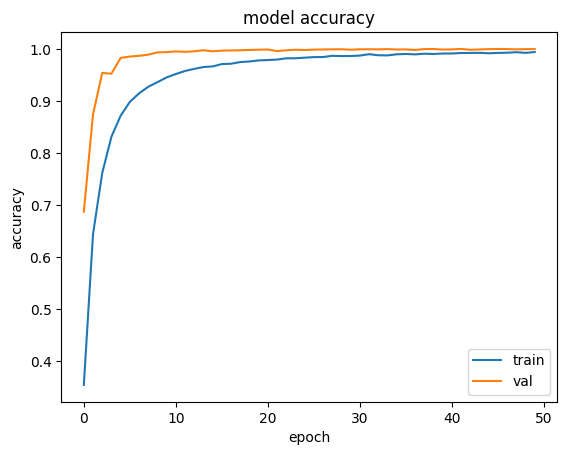

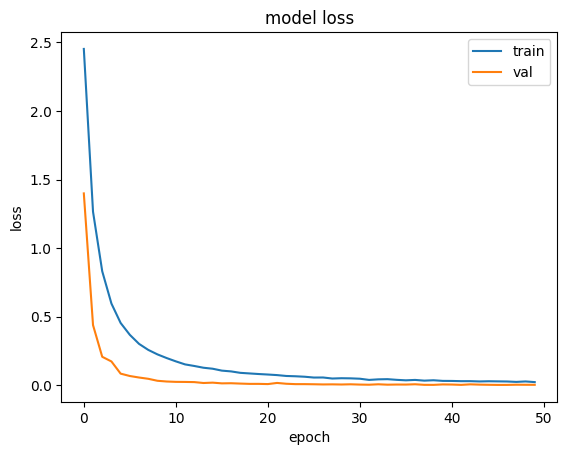

In [28]:
show_history(historyVS)

How to explain these results

In [29]:
modelS.load_weights(file_pathMS)

evalVS = modelS.evaluate(test_ds, verbose=2)
print(evalVS)
valVS = modelS.evaluate(validation_ds, verbose=2)
print(valVS)
tvalVS = modelS.evaluate(trainA_ds, verbose=2)
print(tvalVS)

198/198 - 14s - loss: 0.0596 - accuracy: 0.9817 - 14s/epoch - 70ms/step
[0.059625569730997086, 0.9817101955413818]
123/123 - 4s - loss: 0.0015 - accuracy: 0.9999 - 4s/epoch - 35ms/step
[0.0014694643905386329, 0.9998725056648254]
491/491 - 18s - loss: 0.0156 - accuracy: 0.9963 - 18s/epoch - 37ms/step
[0.015604773536324501, 0.9963018298149109]


## Model 2 - Notebook from Kaggle (https://www.kaggle.com/code/shivank856/gtsrb-cnn-98-test-accuracy/notebook)

In [130]:
def modelK(classCount, imgSize,channels):
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(imgSize, imgSize, channels)))
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization(axis=-1))
    
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization(axis=-1))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.5))
    
    model.add(Dense(classCount, activation='softmax'))
    
    lr = 0.001
    epochs = 30
    opt = Adam(lr=lr, decay=lr / (epochs * 0.5))
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [131]:
modelK = modelK(43, 32, 3)
print(modelK.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 16)        448       
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 10, 128)      

In [48]:
file_pathMK, callbacksMK = prepareCallbacks('dynamic1',log_and_model_pathK)

In [41]:
historyVK = modelK.fit(trainA_ds,
          epochs=50, 
          validation_data = validation_ds, 
          callbacks=callbacksMK)

Epoch 1/50
491/491 [==============================] - ETA: 0s - loss: 1.0755 - accuracy: 0.7179
Epoch 1: val_accuracy improved from -inf to 0.41915, saving model to logs/preprocessingLogs/modelK/preprocessing1\cp.ckpt
491/491 [==============================] - 73s 121ms/step - loss: 1.0755 - accuracy: 0.7179 - val_loss: 2.2613 - val_accuracy: 0.4192
Epoch 2/50
491/491 [==============================] - ETA: 0s - loss: 0.1397 - accuracy: 0.9590
Epoch 2: val_accuracy improved from 0.41915 to 0.98891, saving model to logs/preprocessingLogs/modelK/preprocessing1\cp.ckpt
491/491 [==============================] - 47s 96ms/step - loss: 0.1397 - accuracy: 0.9590 - val_loss: 0.0357 - val_accuracy: 0.9889
Epoch 3/50
491/491 [==============================] - ETA: 0s - loss: 0.0834 - accuracy: 0.9748
Epoch 3: val_accuracy improved from 0.98891 to 0.99005, saving model to logs/preprocessingLogs/modelK/preprocessing1\cp.ckpt
491/491 [==============================] - 46s 94ms/step - loss: 0.0834 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


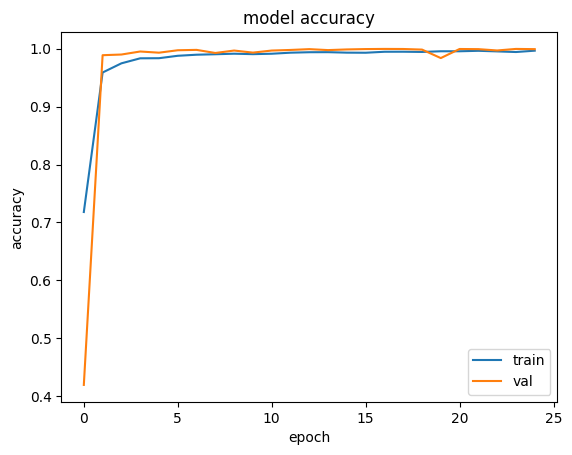

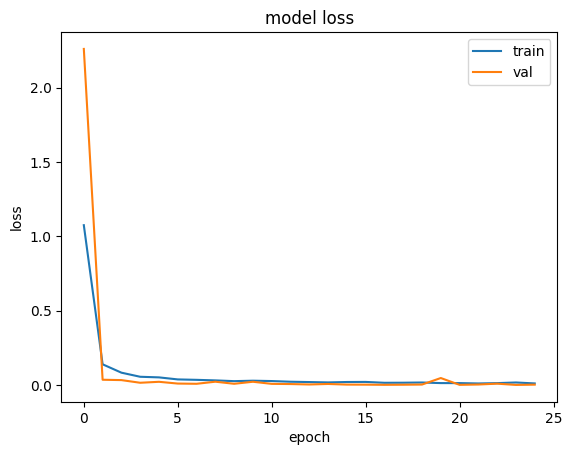

In [44]:
show_history(historyVK)

In [49]:
modelK.load_weights(file_pathMK)

evalVK = modelK.evaluate(test_ds, verbose=2)
print(evalVK)
valVK = modelK.evaluate(validation_ds, verbose=2)
print(valVK)
tvalVK = modelK.evaluate(trainA_ds, verbose=2)
print(tvalVK)

198/198 - 7s - loss: 0.0796 - accuracy: 0.9805 - 7s/epoch - 35ms/step
[0.07955238968133926, 0.9805225729942322]
123/123 - 5s - loss: 0.0015 - accuracy: 0.9996 - 5s/epoch - 38ms/step
[0.0014836100162938237, 0.9996174573898315]
491/491 - 19s - loss: 0.0092 - accuracy: 0.9972 - 19s/epoch - 39ms/step
[0.00915298517793417, 0.9971626400947571]


## Model 3 -  modelGr created by the group 

- Start with larger filtes in order to get low-level features, advance into high-level filters with higher number of filters

In [128]:
def modelGr(classCount, imgSize,channels):
    model = Sequential()
    model.add(Input(shape=(imgSize, imgSize, channels)))

    # Larger filters
    model.add(Conv2D(32, (5, 5)))         
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))   
    #  introduce MaxPooling layers too frequently could result in loss of valuable information
    #model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (5, 5)))         
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))   
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Smaller filters
    #model.add(Conv2D(64, (3, 3)))         
    #model.add(BatchNormalization())
    #model.add(Activation('relu'))   
    #model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5)))         
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))   
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.01))           
    model.add(Dropout(0.4))

    model.add(Dense(classCount, activation='softmax'))

    opt = Adam(lr=0.0001) # Same learning rate and decay as ModelK
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])
    return model

In [129]:
modelGr = modelGr(43, 32, 3)
print(modelGr.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 24, 24, 64)        0

c:\Users\USER\Documents\GitHub\VCPI-uminho\computer-vision\.venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [39]:
file_pathMGr, callbacksMGr = prepareCallbacks('dynamic1',log_and_model_pathGr)

In [40]:
historyVGr = modelGr.fit(trainA_ds,
          epochs=50, 
          validation_data = validation_ds, 
          callbacks=callbacksMGr)

Epoch 1/50
491/491 [==============================] - ETA: 0s - loss: 1.6962 - accuracy: 0.5543
Epoch 1: val_accuracy improved from -inf to 0.90143, saving model to logs/dynamicLogs/modelGr/dynamic1\cp.ckpt
491/491 [==============================] - 59s 117ms/step - loss: 1.6962 - accuracy: 0.5543 - val_loss: 0.3772 - val_accuracy: 0.9014
Epoch 2/50
491/491 [==============================] - ETA: 0s - loss: 0.3338 - accuracy: 0.9028
Epoch 2: val_accuracy improved from 0.90143 to 0.95639, saving model to logs/dynamicLogs/modelGr/dynamic1\cp.ckpt
491/491 [==============================] - 55s 113ms/step - loss: 0.3338 - accuracy: 0.9028 - val_loss: 0.1402 - val_accuracy: 0.9564
Epoch 3/50
491/491 [==============================] - ETA: 0s - loss: 0.1940 - accuracy: 0.9426
Epoch 3: val_accuracy improved from 0.95639 to 0.95728, saving model to logs/dynamicLogs/modelGr/dynamic1\cp.ckpt
491/491 [==============================] - 50s 102ms/step - loss: 0.1940 - accuracy: 0.9426 - val_loss: 0

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


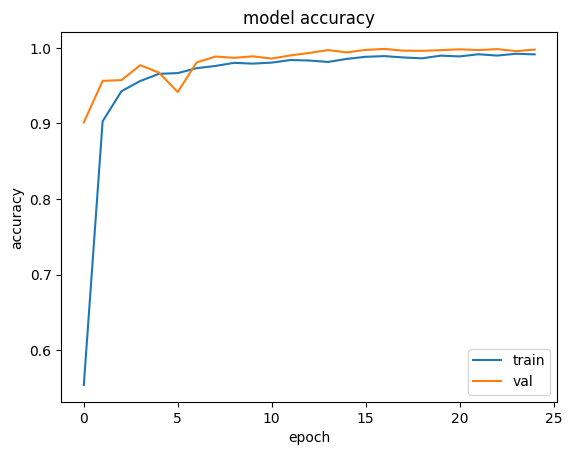

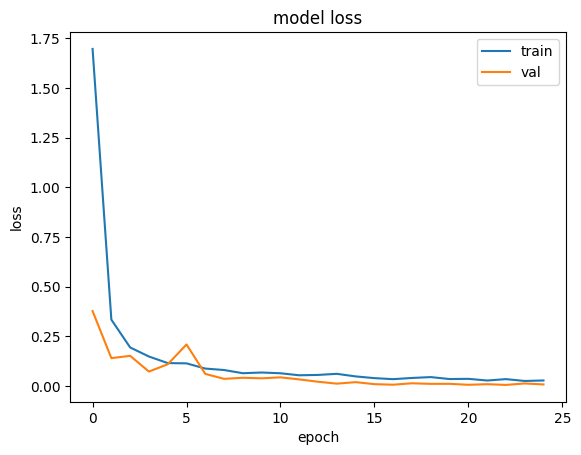

In [41]:
show_history(historyVGr)

In [42]:
modelGr.load_weights(file_pathMGr)

evalVGr = modelGr.evaluate(test_ds, verbose=2)
print(evalVGr)
valVGr = modelGr.evaluate(validation_ds, verbose=2)
print(valVGr )
tvalVGr = modelGr.evaluate(trainA_ds, verbose=2)
print(tvalVGr)

198/198 - 10s - loss: 0.1302 - accuracy: 0.9661 - 10s/epoch - 52ms/step
[0.1301726996898651, 0.9661124348640442]
123/123 - 4s - loss: 0.0066 - accuracy: 0.9986 - 4s/epoch - 36ms/step
[0.006555839441716671, 0.9985973238945007]
491/491 - 19s - loss: 0.0195 - accuracy: 0.9941 - 19s/epoch - 38ms/step
[0.01947975344955921, 0.9940701723098755]


#### Comparing the results for the different models used

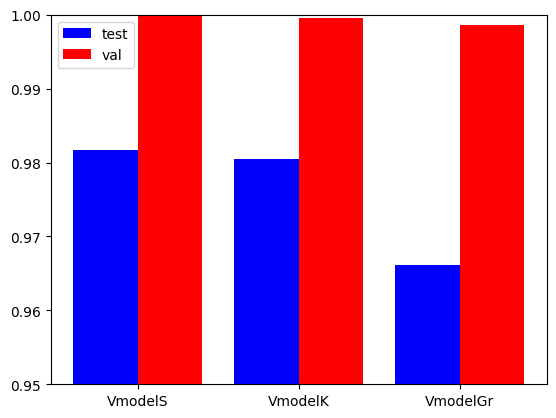

In [53]:
show_accuracies(['VmodelS', 'VmodelK', 'VmodelGr'], [evalVS[1], evalVK[1], evalVGr[1]], [valVS[1], valVK[1], valVGr[1]])

### Dynamic approach 2 - Load the dataset into preprocessing and apply data augmentation after batching

Check that in this step we batch the train dataset before applying any augmentation process or transformation since we want the type of transformations to batch specifically.

Lets try more complicated transformations as we apply a new process_image definition

In [178]:
trainB_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True)

testB_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    label_mode='categorical',
    batch_size=BATCH_SIZE)


AUTOTUNE = tf.data.AUTOTUNE  #adjust the amount of parallelism depending on the available system resources

Found 39209 files belonging to 43 classes.
Found 12630 files belonging to 43 classes.


In [179]:
trainB_ds, validationB_ds = create_validation_set(trainB_ds,0.2,True)

In [180]:
def normalize(images,labels):
    images = tf.cast(images,tf.float32)
    images /=255
    return images, labels

trainB_ds = trainB_ds.map(normalize,num_parallel_calls=AUTOTUNE)
validationB_ds = validationB_ds.map(normalize,num_parallel_calls=AUTOTUNE)
testB_ds = testB_ds.map(normalize,num_parallel_calls=AUTOTUNE)

In [181]:
trainB_ds = trainB_ds.cache()
trainB_ds = trainB_ds.shuffle(buffer_size=10200)
trainB_ds = trainB_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [182]:
validationB_ds = validationB_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [183]:
testB_ds = testB_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Different types of augment definitions:

More control with different augment types

In [184]:
def process_brightness(image, label):
   
    image = tf.expand_dims(image, 0)
    # Apply brightness adjustment
    img = tfa.image.random_hsv_in_yiq(image, 0.0, 1.0, 1.0, 0.1, 3.0)
    # Remove the batch dimension
    img = tf.squeeze(img, 0)
    # Clip values to be between 0 and 1
    img = tf.clip_by_value(img, 0, 1)
    
    return img, label

def process_saturation(image, label):
    
    img = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.0, 1.0, 3.0, 1.0, 1.0),0,1)
    return img, label

def process_contrast(image, label):
    image = tf.expand_dims(image, 0)
    img= tf.image.random_contrast(image, lower=0.1, upper=3.0, seed=None)
    img = tf.squeeze(img, 0)
    img = tf.clip_by_value(img,0,1)
    return img, label

def process_hue(image, label):
    
    img = tf.image.random_hue(image, max_delta=0.2, seed=None)
    return img, label

def process_rotate(image, label):
    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    return img, label

def process_image_rotate(image,label):
    r = tf.random.uniform(shape=(), minval=0, maxval=0.5)
    image = tfa.image.rotate(image, r)
    image = tfa.image.random_hsv_in_yiq(image, 0.0, 0.4, 1.1, 0.4, 1.1)
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label
    
def process_shear(image, label):
    
    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    sx = tf.random.uniform(shape=(), minval=-0.1, maxval=0.1, dtype=tf.dtypes.float32)
    img = tfa.image.transform(img, [1, sx, -sx*32,   0,1,0,  0,0])
    return img, label

def process_translate(image, label):
    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    tx = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)
    ty = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)  
    img = tfa.image.translate(img, [tx,ty])
    return img, label

def process_crop(image, label):
    c = tf.random.uniform(shape=(), minval=24, maxval=32, dtype=tf.dtypes.float32)
    img = tf.image.random_crop(image, size=[c,c,3])
    img = tf.image.resize(img ,size= [IMAGE_HEIGHT,IMAGE_WIDTH])
    return img, label

More constructed process_augment

In [206]:
def process_augment(image,label):
    # Random rotation in a range to simulate different viewing angles.
    image, label = process_rotate(image, label)
    
    # Continue with a random translation (shift) to simulate different positioning of the sign in the image.
    image, label = process_translate(image, label)
    
    # slight skew in perspective.
    image, label = process_shear(image, label)
    
    # Changing contrast and brightness can simulate different lighting conditions.
    image, label = process_contrast(image, label)
    image, label = process_brightness(image, label)
    
    # Hue and saturation changes can simulate different camera color settings and different times of day.
    # But it's crucial to ensure that these don't disrupt the colors of the signs too much as color can be an important classifying feature.
    # Therefore, we should use these sparingly and with smaller deltas.
    #image, label = process_hue(image, label)
    #image, label = process_saturation(image, label)
    
    return image,label

In [207]:
trainB_ds_aug = trainB_ds
trainB_ds_aug = trainB_ds_aug.cache()
trainB_ds_aug = trainB_ds_aug.shuffle(buffer_size=10200)
trainB_ds_aug = trainB_ds_aug.map(process_augment)
trainB_ds_aug = trainB_ds_aug.prefetch(buffer_size=AUTOTUNE)

In [203]:
print(trainB_ds.take(1))
print(trainB_ds_aug.take(1))

<TakeDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 43), dtype=tf.float32, name=None))>
<TakeDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 43), dtype=tf.float32, name=None))>


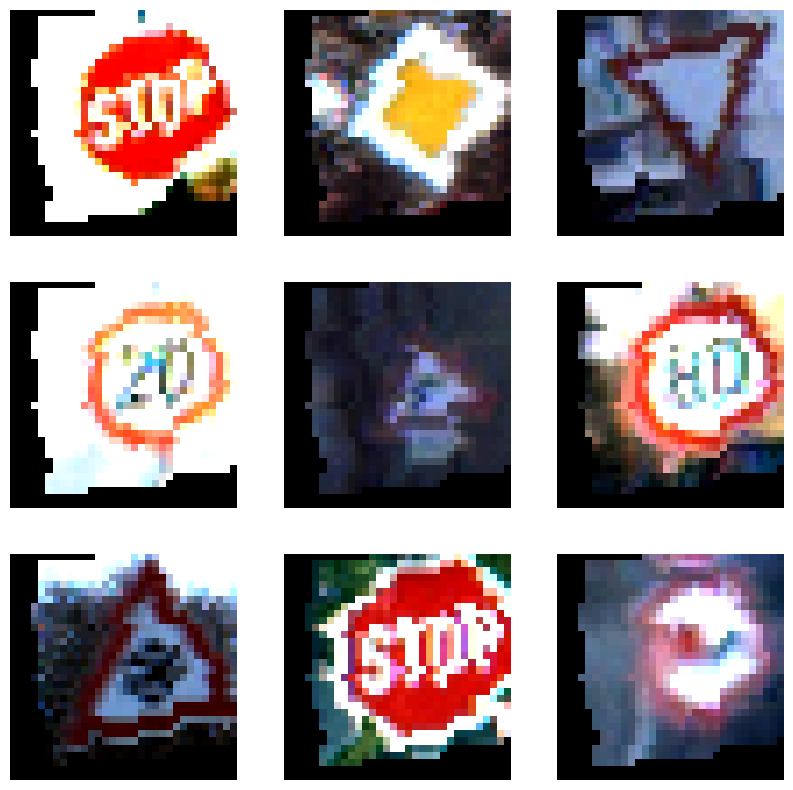

In [208]:
for images, _ in trainB_ds_aug.take(1):
    visualize_augment(images,_)

In [209]:
file_pathMGrD2, callbacksMGrD2 = prepareCallbacks('dynamic2',log_and_model_pathGr)

In [210]:
historyVGrD2 = modelGr.fit(trainB_ds_aug,
          epochs=50, 
          validation_data = validationB_ds, 
          callbacks=callbacksMGrD2)

Epoch 1/50
490/490 [==============================] - ETA: 0s - loss: 2.4171 - accuracy: 0.3482
Epoch 1: val_accuracy improved from -inf to 0.60747, saving model to logs/dynamicLogs/modelGr/dynamic2\cp.ckpt
490/490 [==============================] - 63s 106ms/step - loss: 2.4171 - accuracy: 0.3482 - val_loss: 1.4158 - val_accuracy: 0.6075
Epoch 2/50
490/490 [==============================] - ETA: 0s - loss: 1.4451 - accuracy: 0.5740
Epoch 2: val_accuracy improved from 0.60747 to 0.83041, saving model to logs/dynamicLogs/modelGr/dynamic2\cp.ckpt
490/490 [==============================] - 39s 80ms/step - loss: 1.4451 - accuracy: 0.5740 - val_loss: 0.6351 - val_accuracy: 0.8304
Epoch 3/50
490/490 [==============================] - ETA: 0s - loss: 1.0881 - accuracy: 0.6705
Epoch 3: val_accuracy improved from 0.83041 to 0.88542, saving model to logs/dynamicLogs/modelGr/dynamic2\cp.ckpt
490/490 [==============================] - 38s 78ms/step - loss: 1.0881 - accuracy: 0.6705 - val_loss: 0.4

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


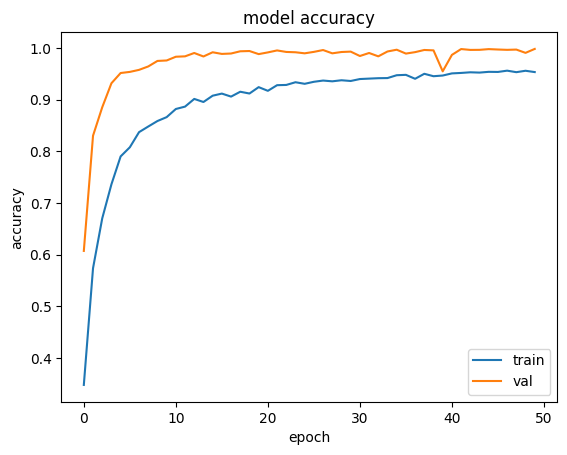

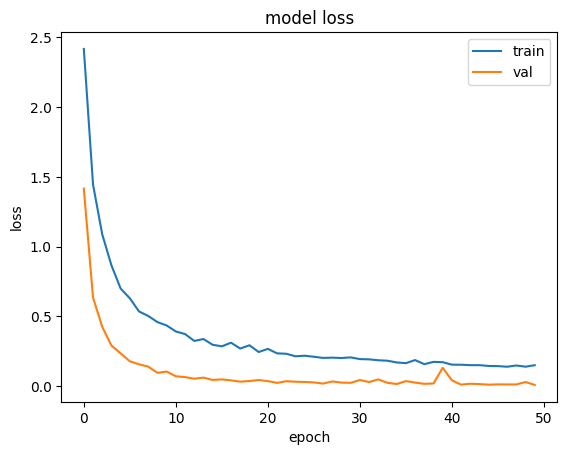

In [211]:
show_history(historyVGrD2)

### Dynamic approach 3 - Load the dataset into preprocessing and apply data augmentation through two-phase strategy

Check that in this step we batch the train dataset before applying any augmentation process or transformation since we want the type of transformations to batch specifically.

Our model will first learn the foundational features from the original data, which is important for a complex dataset like GTSRB that contains images of various traffic signs. Once the model has a solid understanding of these core features, introducing data augmentation can help to improve its generalization by presenting it with additional variations and complexities to learn from.

The callback method will save the best model over both phases.


In [92]:
# Load the dataset into preprocessing
# Use keras.preprocessing method to load data from the directory
train2P_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True)

test2P_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    label_mode='categorical',
    batch_size=BATCH_SIZE)


AUTOTUNE = tf.data.AUTOTUNE  #adjust the amount of parallelism depending on the available system resources

Found 39209 files belonging to 43 classes.
Found 12630 files belonging to 43 classes.


In [93]:
train2P_ds, validation2P_ds = create_validation_set(train2P_ds,0.2,True)

In [94]:
# Normalize method
def normalize(images,labels):
    images = tf.cast(images,tf.float32)
    images /=255
    return images, labels

train2P_ds = train2P_ds.map(normalize,num_parallel_calls=AUTOTUNE)
validation2P_ds = validation2P_ds.map(normalize,num_parallel_calls=AUTOTUNE)
test2P_ds = test2P_ds.map(normalize,num_parallel_calls=AUTOTUNE)

In [15]:
print('Number of batches train: ', train2P_ds.cardinality().numpy())
print('Number of batches validation: ',validation2P_ds.cardinality().numpy())
print('Number of batches test: ',test2P_ds.cardinality().numpy())

Number of batches train:  490
Number of batches validation:  123
Number of batches test:  198


In [95]:
train2P_ds = train2P_ds.cache()
train2P_ds = train2P_ds.shuffle(buffer_size=10200)
train2P_ds = train2P_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [96]:
validation2P_ds = validation2P_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [97]:
test2P_ds = test2P_ds.cache().prefetch(buffer_size=AUTOTUNE)

##### Simple process_augment for 2P

In [105]:
def process_augment2(image,label):
    #image = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    #img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    #tx = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)
    #ty = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)  
    #img = tfa.image.translate(img, [tx,ty])
    image,label = process_image_rotate(image,label)
    image = tf.image.random_brightness(image,max_delta=0.3)
    image = tf.image.random_contrast(image,0.2,0.5)
    return image,label


Finally we can start following the two-phase approach

In [33]:
file_pathMGrD3, callbacksMGrD3 = prepareCallbacks('dynamic3_2',log_and_model_pathGr)

total_epochs = 50
initial_epochs = 10

In [ ]:
# training with normal data for 10 epochs
historyVGrD3 = modelGr.fit(train2P_ds,
          epochs=initial_epochs, 
          validation_data = validation2P_ds, 
          callbacks=callbacksMGrD3)

In [106]:
train2P_ds_aug = train2P_ds
train2P_ds_aug = train2P_ds_aug.cache()
train2P_ds_aug = train2P_ds_aug.shuffle(buffer_size=10200)
train2P_ds_aug = train2P_ds_aug.map(process_augment2)
train2P_ds_aug = train2P_ds_aug.prefetch(buffer_size=AUTOTUNE)

In [108]:
print(train2P_ds_aug.take(1))
print(train2P_ds.take(1))

<TakeDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 43), dtype=tf.float32, name=None))>
<TakeDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 43), dtype=tf.float32, name=None))>


Check on some augmented and transformed images

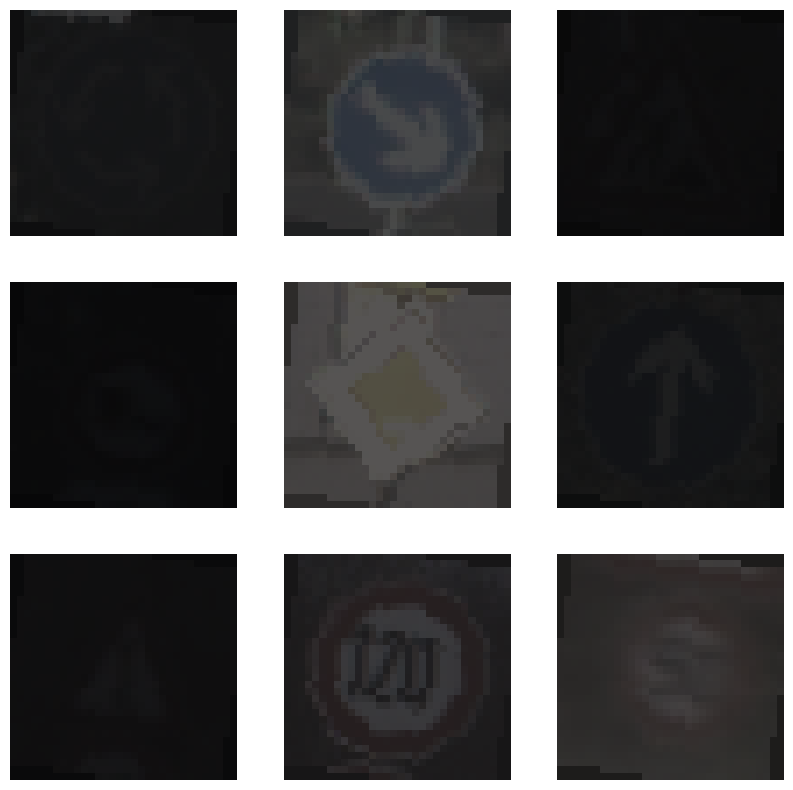

In [112]:
for images, _ in train2P_ds_aug.take(1):
    visualize_augment(images,_)

In [ ]:
# Second phase of training on augmented data
historyVGrD3_2 = modelGr.fit(train2P_ds_aug,
                       epochs=total_epochs - initial_epochs,
                       validation_data=validation2P_ds,
                       callbacks=callbacksMGrD3)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


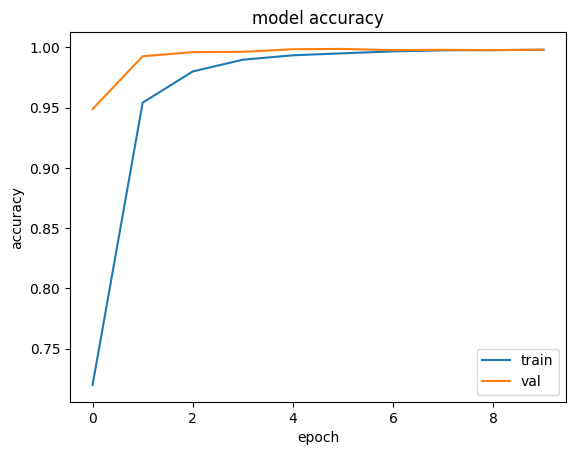

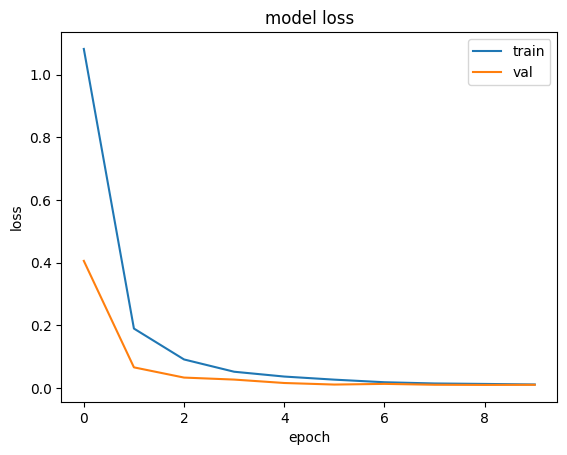

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


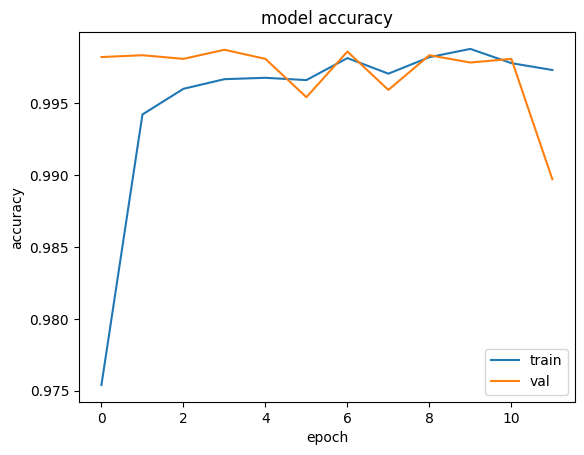

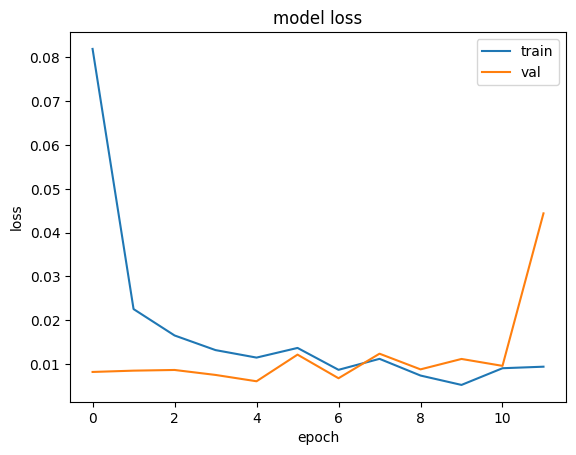

In [35]:
show_history(historyVGrD3)
show_history(historyVGrD3_2)

In [36]:
modelGr.load_weights(file_pathMGrD3)

evalVGr3 = modelGr.evaluate(test2P_ds, verbose=2)
print(evalVGr3)
valVGr3 = modelGr.evaluate(validation2P_ds, verbose=2)
print(valVGr3)
tvalVGr3 = modelGr.evaluate(train2P_ds, verbose=2)
print(tvalVGr3)

198/198 - 11s - loss: 0.1569 - accuracy: 0.9715 - 11s/epoch - 56ms/step
[0.15686017274856567, 0.9714964628219604]
123/123 - 4s - loss: 0.0075 - accuracy: 0.9987 - 4s/epoch - 31ms/step
[0.007508354727178812, 0.9987296462059021]
490/490 - 15s - loss: 0.0018 - accuracy: 0.9994 - 15s/epoch - 30ms/step
[0.0018108764197677374, 0.9993937015533447]
